**Carga de datos**



In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [2]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Magazine_Subscriptions.json.gz

--2023-09-03 12:51:50--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Magazine_Subscriptions.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12875273 (12M) [application/x-gzip]
Saving to: ‘Magazine_Subscriptions.json.gz’

Magazine_Subscripti 100%[===================>]  12.28M  --.-KB/s    in 0.1s    

2023-09-03 12:51:50 (92.1 MB/s) - ‘Magazine_Subscriptions.json.gz’ saved [12875273/12875273]



In [3]:
### load the meta data

data = []
with gzip.open('Magazine_Subscriptions.json.gz') as f:
  for l in f:
        data.append(json.loads(l.strip()))

In [4]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

89689


In [5]:
column_names = df.columns.tolist()
print(column_names)

['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'style', 'image']


In [6]:
#Balance the df
with gzip.open('Magazine_Subscriptions.json.gz', 'rb') as f:
  df = pd.read_json(f, lines=True)

filtered_df = df[df['overall'].isin([1, 2, 4, 5])]


num_samples = 2000
sampled_df_1 = filtered_df[filtered_df['overall'] == 1].sample(n=num_samples)
sampled_df_2 = filtered_df[filtered_df['overall'] == 2].sample(n=num_samples)
sampled_df_4 = filtered_df[filtered_df['overall'] == 4].sample(n=num_samples)
sampled_df_5 = filtered_df[filtered_df['overall'] == 5].sample(n=num_samples)


result_df = pd.concat([sampled_df_1, sampled_df_2, sampled_df_4, sampled_df_5])

result_df.to_csv('sampled_data_file.csv', index=False)

###### need to be working with result_df, this is why my reviews are unbalanced

# **Análisis Exploratorio**

In [7]:
review_sample = result_df['reviewText'].head()
print(review_sample)

70303    I don't mean to cast broad aspersions against ...
52090    I am unable to download People Magazine on my ...
42547    too complicated!!!! I am going to discontinue it.
58157    I keep track of the expiration dates of the ma...
32367    Ordered. Paid for. Order acknowledged. NEVER R...
Name: reviewText, dtype: object


In [8]:
result_df.head

<bound method NDFrame.head of        overall vote  verified   reviewTime      reviewerID        asin  \
70303        1    9     False  04 17, 2014   AH8A7ICD6EIAY  B00FDWVIHO   
52090        1   54     False  03 20, 2014   A9O14MDWW07KZ  B000ILVRWQ   
42547        1  NaN     False  10 27, 2014  A2GXSMJX6LIZGE  B0000AWD92   
58157        1    2      True  01 25, 2013  A133L1CHT4TRFK  B000OPOEEE   
32367        1   17      True  02 10, 2007  A1VIUGQLE20F2O  B00006K37V   
...        ...  ...       ...          ...             ...         ...   
73988        5  NaN      True   04 1, 2017   AUQ7I62QNXF28  B01CF3ECNK   
76935        5  NaN      True  12 16, 2017  A1BVSLZM52XI3N  B000066T09   
30795        5    2      True   11 7, 2013  A1859W4CKRNHXM  B00006J9HW   
46248        5  NaN      True  11 22, 2015  A13E5GFPBSABC1  B000BW56WO   
44552        5  NaN     False  04 20, 2016   AUN8EQXSJO3H3  B00079RO7G   

          reviewerName                                         reviewText  \
7030

Pre Procesamiento
Limpieza de datos, dropear columnas no necesarias
Distribución de reviews por sentimiento
para asegurarme de que este balanceado

In [9]:
#convert to lower case
lc_reviews = result_df['reviewText'].str.lower().str.split()

In [10]:
import pandas as pd
import string
#remove punctuation
result_df['reviewText'] = result_df['reviewText'].str.replace(f"[{string.punctuation}]", "")

<ipython-input-10-acd4c7768910>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  result_df['reviewText'] = result_df['reviewText'].str.replace(f"[{string.punctuation}]", "")


In [11]:
#drop nas for relevant columns
result_df = result_df.dropna(subset=['reviewText', 'overall'])

In [12]:
#drop unnecessary columns
column_keep = ['reviewText', 'overall']
result_df = result_df[column_keep]
#check remaining columns
column_names = result_df.columns.tolist()
print(column_names)

['reviewText', 'overall']


# Distribución de reviews por número de estrellas

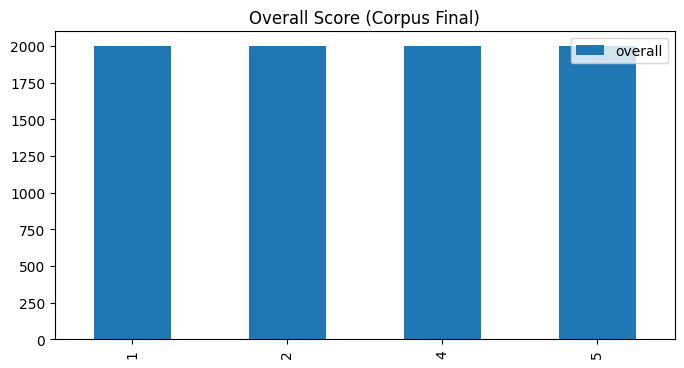

In [13]:
#distribution of overall review score (this shows that my df is balanced)
aux_df = pd.DataFrame(result_df['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall Score (Corpus Final)', figsize=(8, 4))

In [14]:
#create positive and negative review classes
def label_overall(row):
  if int(row['overall']) < 3:
      return 1
  else:
      return 0

In [15]:
result_df['overall_label'] = df.apply(lambda row: label_overall(row), axis=1)

In [16]:
result_df.head()

,reviewText,overall,overall_label
70303,I dont mean to cast broad aspersions against a...,1,1
52090,I am unable to download People Magazine on my ...,1,1
42547,too complicated I am going to discontinue it,1,1
58157,I keep track of the expiration dates of the ma...,1,1
32367,Ordered Paid for Order acknowledged NEVER RECI...,1,1


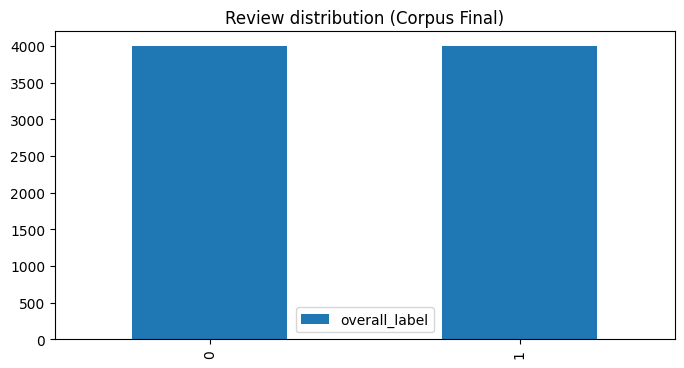

In [17]:
aux_df = pd.DataFrame(result_df['overall_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Review distribution (Corpus Final)', figsize=(8, 4))

In [18]:
#convert the review texts into list from corpus
words_list = [reviewText.split() for reviewText in result_df['reviewText']]


In [19]:
#most commmon words
from collections import Counter
#flatten the list of lists
flattened_words = [word for sublist in words_list for word in sublist]
word_freq = Counter(flattened_words)
most_common_words = word_freq.most_common()
top_10 = 10
for word, freq in most_common_words[:top_10]:
  print(f"{word}: {freq}")

the: 17316
I: 13223
to: 12061
and: 11440
a: 9881
of: 8206
is: 6414
it: 6228
magazine: 6198
for: 5922


Visualizacion de palabras más frequentes


In [20]:
#visualizacion de palabras más frequentes
from collections import Counter
import matplotlib.pyplot as plt

top_n = 10
top_10 = most_common_words[:top_n]

words = [w[0] for w in top_10]
freq = [w[1] for w in top_10]

In [21]:
freq, words = zip(*sorted(zip(freq, words)))

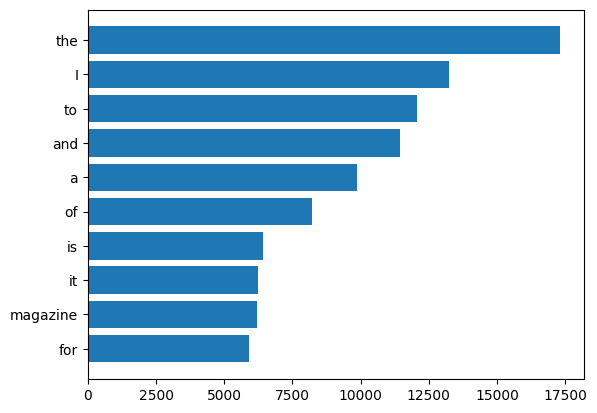

In [22]:
plt.barh(words, freq)
plt.show()

N-grams más frecuentes

In [23]:
#most common n-grams (2 and 3 word pairs)
from nltk import ngrams
from nltk.probability import FreqDist

bigrams_two = [list(ngrams(words, 2)) for words in words_list]
trigrams_three = [list(ngrams(words, 3)) for words in words_list]


In [24]:
#conjuntos de palabras más comunes
from nltk.probability import FreqDist

# Flatten the lists of n-grams
flat_bigrams = [bigram for sublist in bigrams_two for bigram in sublist]
flat_trigrams = [trigram for sublist in trigrams_three for trigram in sublist]

# Calculate frequency distributions
bigrams_freq = FreqDist(flat_bigrams)
trigrams_freq = FreqDist(flat_trigrams)

print("Most common bigrams:", bigrams_freq.most_common(10))
print("Most common trigrams:", trigrams_freq.most_common(10))

Most common bigrams: [(('of', 'the'), 1929), (('this', 'magazine'), 1583), (('the', 'magazine'), 1410), (('in', 'the'), 1156), (('I', 'have'), 1122), (('to', 'be'), 868), (('is', 'a'), 832), (('for', 'the'), 791), (('to', 'the'), 742), (('on', 'the'), 741)]
Most common trigrams: [(('a', 'lot', 'of'), 234), (('of', 'the', 'magazine'), 227), (('I', 'have', 'been'), 184), (('used', 'to', 'be'), 151), (('This', 'magazine', 'is'), 151), (('this', 'magazine', 'is'), 142), (('This', 'is', 'a'), 142), (('some', 'of', 'the'), 133), (('the', 'magazine', 'is'), 131), (('to', 'be', 'a'), 125)]


In [25]:
print(words_list)
print(most_common_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
import unicodedata
import re
def sentence_normalization(sentence):
    sentence = unicodedata.normalize('NFKD', sentence).lower().encode('ascii', errors='ignore').decode('utf-8')
    sentence = re.sub(' +', ' ', ' '.join([word if word.isalpha() else '' for word in sentence.split()])).strip()
    return sentence

In [27]:
def remove_stopwords(sentence, sw_list):
    sentence = ' '.join([word for word in sentence.split() if word not in sw_list])
    return sentence

In [28]:
!pip install stop-words
from stop_words import get_stop_words
sw_list = get_stop_words('en')


  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32896 sha256=e3ba45c719014f3b086feabfa9acd2981f5b33e635ae6c59d7fffcc8493836f2
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [29]:
def process_reviews(reviews, sw_list):
    processed_sentences = []
    for sent in result_df['reviewText']:
        if not sent != sent:  # check if sent is not nan
            sent = sentence_normalization(sent)
            sent = remove_stopwords(sent, sw_list)
            processed_sentences.append(sent)
        else:
            processed_sentences.append('None')
    return processed_sentences

In [30]:
processed_reviews = process_reviews(result_df['reviewText'], sw_list)

In [32]:
print('Review original: {}'.format(result_df['reviewText'].values[0]))
print('Review procesada: {}'.format(processed_reviews[0]))

Review original: I dont mean to cast broad aspersions against aspiring writers I admire them for working hard at their craft and for finding an avenue by which they can share their work with the world

Unfortunately on the whole the submissions arent particularly compelling  After receiving about four issues I noticed that the quality of narrative in each issue was at the level of a welledited undergraduate creative writing piece in that each seemed veryI dont knowsurfacey  If youre interested in suburban stories with bathetic resolutions or just want to be supportive of new writers by all means subscribe but this stuff aint for me
Review procesada: dont mean cast broad aspersions aspiring writers admire working hard craft finding avenue can share work world unfortunately whole submissions arent particularly compelling receiving four issues noticed quality narrative issue level welledited undergraduate creative writing piece seemed veryi dont knowsurfacey youre interested suburban stor

In [33]:
result_df.loc[:, 'processedReview'] = processed_reviews

In [34]:
import random
import numpy as np

result_df['processedReview'] = result_df['processedReview'].replace('', np.nan)
result_df = result_df.dropna(subset=['processedReview'])

Word Cloud
(ahora con las most common words, pero antes de quitar las stop words)

In [35]:
#Word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [36]:
top_n = 10
top_10 = most_common_words[:top_n]
words_list = [word[0] for word in top_10]

In [37]:
def plot_word_cloud(words_list):
    wordcloud = WordCloud(max_font_size=50, max_words=10, background_color="white").generate(' '.join(words_list))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

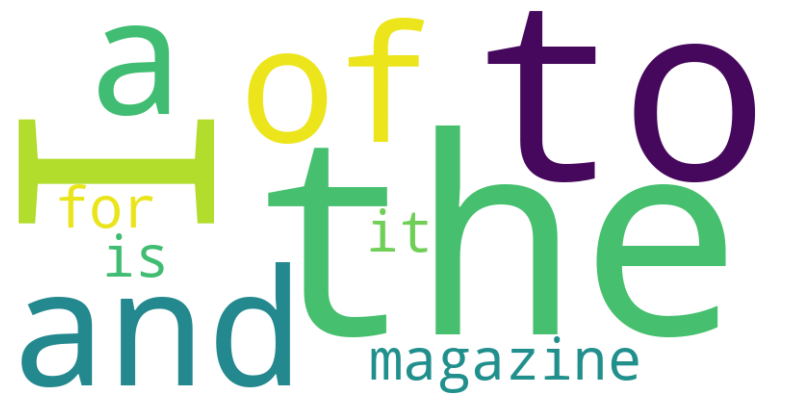

In [38]:
words_list = ['the', 'I', 'to', 'and', 'a', 'of', 'magazine', 'is', 'it', 'for']
#convert list into string
words_text = ' '.join(words_list)
word_freq = {word: words_list.count(word) for word in words_list}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
#plot_word_cloud(words_list)

In [39]:
#tokenize df
import nltk
from nltk.tokenize import word_tokenize


In [40]:
nltk.download('punkt')
result_df['tokenized_text'] = result_df['processedReview'].apply(word_tokenize)
for tokens in result_df['tokenized_text'][:10]:
  print(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['dont', 'mean', 'cast', 'broad', 'aspersions', 'aspiring', 'writers', 'admire', 'working', 'hard', 'craft', 'finding', 'avenue', 'can', 'share', 'work', 'world', 'unfortunately', 'whole', 'submissions', 'arent', 'particularly', 'compelling', 'receiving', 'four', 'issues', 'noticed', 'quality', 'narrative', 'issue', 'level', 'welledited', 'undergraduate', 'creative', 'writing', 'piece', 'seemed', 'veryi', 'dont', 'knowsurfacey', 'youre', 'interested', 'suburban', 'stories', 'bathetic', 'resolutions', 'just', 'want', 'supportive', 'new', 'writers', 'means', 'subscribe', 'stuff', 'aint']
['unable', 'download', 'people', 'magazine', 'kindle', 'firespoke', 'long', 'time', 'last', 'saturday', 'representative', 'south', 'africa', 'unable', 'resolve', 'problem', 'turned', 'technicians', 'received', 'call', 'back', 'yet', 'anyone', 'resolving', 'problem', 'best', 'cancel', 'subscription', 'just', 'buy', 'newstand']
['complicated', 'going', 'discontinue']
['keep', 'track', 'expiration', 'dates'

In [41]:
#recount the most common words after removing the stop words
from collections import Counter
word_freq = Counter(result_df['tokenized_text'].sum())
n_most_common = 10
most_common_words = word_freq.most_common(n_most_common)

for word, freq in most_common_words:
  print(f"{word}: {freq}")


magazine: 6525
subscription: 2066
like: 1916
articles: 1698
issue: 1667
one: 1561
great: 1501
read: 1499
good: 1466
just: 1422


In [42]:
most_common_words = [word for word, _ in most_common_words]
print(most_common_words)

['magazine', 'subscription', 'like', 'articles', 'issue', 'one', 'great', 'read', 'good', 'just']


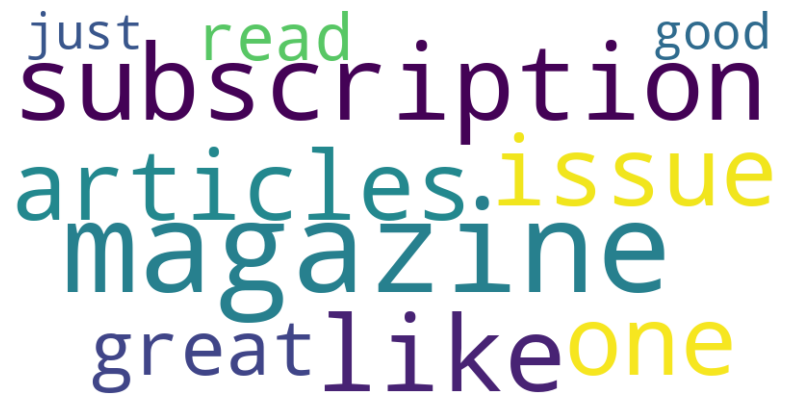

In [91]:
words_list = most_common_words
#convert list into string
words_text = ' '.join(words_list)
word_freq = {word: words_list.count(word) for word in words_list}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
#plot_word_cloud(words_list)

In [43]:
top_5 = most_common_words[:5]
print(top_5)

['magazine', 'subscription', 'like', 'articles', 'issue']


In [44]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

# Initialize lemmatizer and word set
lemmatizer = WordNetLemmatizer()
word_set = set(words.words())

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    filtered_tokens = [token for token in tokens if token.lower() not in sw_list and token.isalpha()]

    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in filtered_tokens]

    # Filter out short or non-English words
    cleaned_tokens = [token for token in lemmatized_tokens if len(token) > 1 and token in word_set]

    return cleaned_tokens

# Apply preprocessing
result_df['processedReview'] = result_df['reviewText'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Modelado

Separamos el conjunto de train y test texto

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve



In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    result_df['processedReview'],
    result_df['overall_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [47]:
#checking to see if the split was done correctly
X_train.iloc[:10]

25       [build, computer, many, people, build, compute...
37948    [read, find, enjoyable, size, car, read, wait,...
84808    [cost, year, expensive, paper, come, time, yea...
87107    [good, magazine, problem, print, small, ink, l...
69308     [buy, daughter, love, magazine, will, keep, get]
8896     [many, one, single, finish, product, point, ma...
61088    [like, magazine, think, helpful, job, financia...
4790     [felt, magazine, focus, much, advertise, work,...
85844                                                   []
500      [advice, good, cancel, due, conflict, opinion,...
Name: processedReview, dtype: object

In [48]:
y_train.iloc[:10]

25       1
37948    0
84808    1
87107    0
69308    0
8896     1
61088    1
4790     1
85844    0
500      1
Name: overall_label, dtype: int64

**Feature Extraction**

Create and train a Word2Vec model. Then, plot the top 5 most common words and their 10 most similar words.


No me ha quedado tan bien como el ejemplo que nos hiciste en clase, pero me ha costado conseguirlo. Luego lo reviso para ver si soy capaz de arreglarlo!

In [49]:
from gensim.models import Word2Vec

# Convert DataFrame column to a list of lists
sentences = result_df['tokenized_text'].tolist()

# Create and train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)


In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

#create a dictionary for similar words
similar_words ={}
for word in top_5:
  similar_words[word] = [similar_word for similar_word, _ in model.wv.most_similar(word, topn=10)]


In [51]:
#extract embeddings for most common wordss and their similar words
word_embeddings = [model.wv[word] for word in top_5 + sum(similar_words.values(), [])]

In [52]:
#convert to array
word_embeddings_array = np.array(word_embeddings)


In [53]:
#reduce to 2D with t-sne
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(word_embeddings_array)

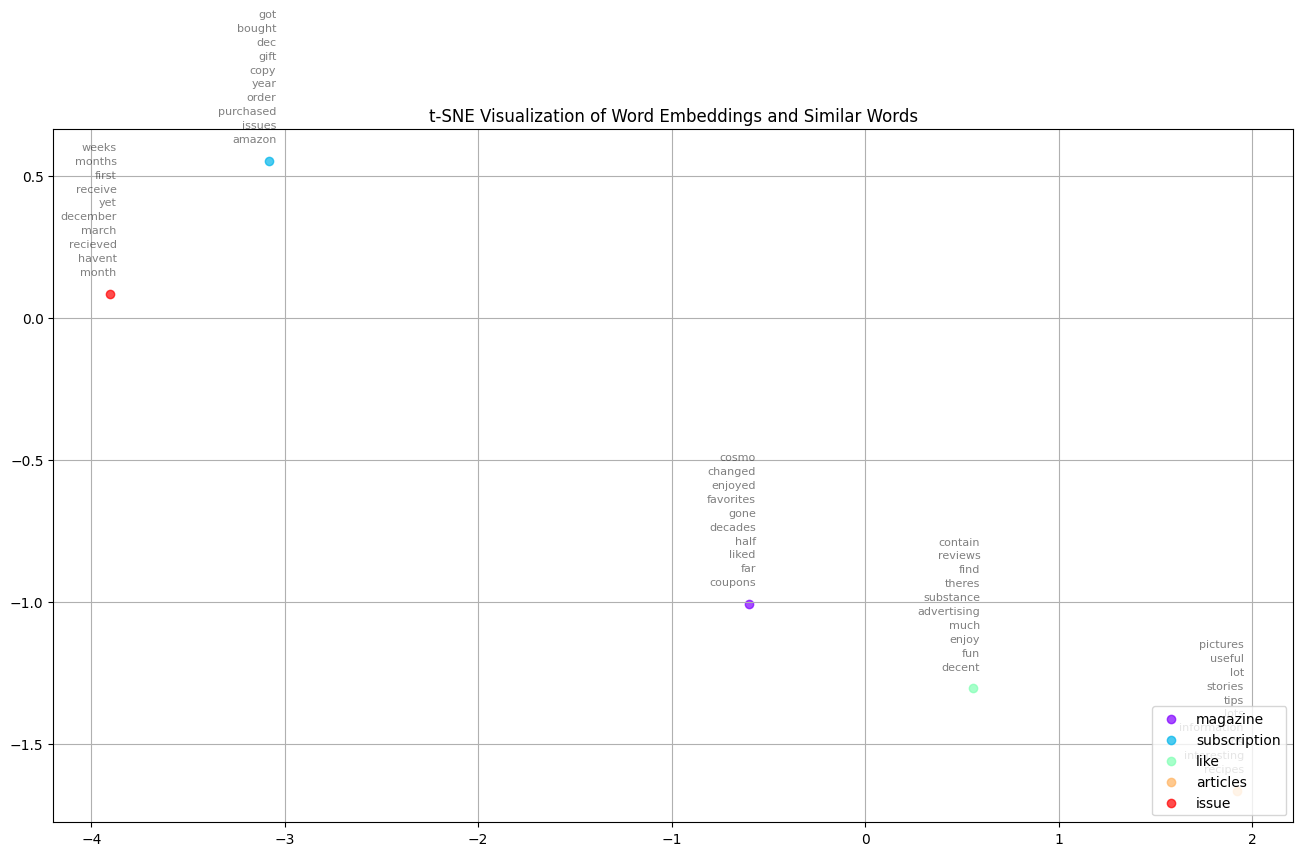

In [54]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def tsne_plot_similar_words(labels, embeddings, similar_words, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))

    for label, coords, words, color in zip(labels, embeddings, similar_words.values(), colors):
        x, y = coords
        plt.scatter(x, y, c=[color], alpha=a, label=label)

        for i, word in enumerate(words):
            annotation_offset = (i + 1) * 10  # Increase this value to space out the annotations more
            plt.annotate(word, alpha=0.5, xy=(x, y), xytext=(5, 2 + annotation_offset),
                     textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.grid(True)
    plt.title('t-SNE Visualization of Word Embeddings and Similar Words')
    plt.show()


tsne_plot_similar_words(top_5, tsne_results, similar_words)


### **TF-IDF Matrix**

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokenized lists back into strings DOUBLE CHECK
X_train_strings = [' '.join(tokens) for tokens in X_train]
X_test_strings = [' '.join(tokens) for tokens in X_test]

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the training and test data
tfidf_matrix_x_train = tfidf_vectorizer.fit_transform(X_train_strings)
tfidf_matrix_x_test = tfidf_vectorizer.transform(X_test_strings)


In [57]:
#get feature names for later analysis
feature_names_train_test = tfidf_vectorizer.get_feature_names_out()


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


corpus_tokenized = result_df['tokenized_text']

# Convert list of tokenized sentences to list of strings
corpus_strings = [' '.join(tokens) for tokens in corpus_tokenized]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_strings)

# Get feature names and IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
idf_scores = tfidf_vectorizer.idf_

# Create a DataFrame with feature names and IDF scores
idf_df = pd.DataFrame({'Word': feature_names, 'IDF': idf_scores})

# Sort the DataFrame by IDF scores
idf_df = idf_df.sort_values(by='IDF', ascending=False)

n_words = 10
print(f"Top {n_words} words with highest TF-IDF in the review:")
print(idf_df.head(n_words))

print(f"\nTop {n_words} words with lowest TF-IDF in the review:")
print(idf_df.tail(n_words))


Top 10 words with highest TF-IDF in the review:
               Word       IDF
0              aaah  9.292799
10589        morgue  9.292799
10572           mop  9.292799
10573         mopar  9.292799
10574        mopars  9.292799
10575           mor  9.292799
10576         morae  9.292799
10582        morbid  9.292799
10583      morbidly  9.292799
10584  moreattitude  9.292799

Top 10 words with lowest TF-IDF in the review:
               Word       IDF
8908           just  2.955973
11441           one  2.925470
8686          issue  2.915222
13393          read  2.894204
7032           good  2.849463
7169          great  2.831331
990        articles  2.798289
9469           like  2.730355
16077  subscription  2.677403
9786       magazine  1.694901


In [59]:
# Check the shape of tfidf_matrix_x_train
num_samples_tfidf_matrix = tfidf_matrix_x_train.shape[0]

# Check the number of rows in overall label
num_samples_sentiment_class = result_df['overall_label'].shape[0]

# Compare the number of samples
if num_samples_tfidf_matrix == num_samples_sentiment_class:
    print("Number of samples match between tfidf_matrix_x_train and overall_label.")
else:
    print("Number of samples do not match between tfidf_matrix_x_train and overall_label.")


Number of samples do not match between tfidf_matrix_x_train and overall_label.


In [60]:
print("Number of rows in result_df:", len(result_df))
print("Number of rows in overall_label:", len(result_df['overall_label']))


Number of rows in result_df: 7989
Number of rows in overall_label: 7989


In [61]:
print(tfidf_matrix_x_train.shape)
print(result_df['overall_label'].shape)

(5991, 7134)
(7989,)


In [65]:
total_samples = len(result_df)

num_train_samples = int(total_samples * 0.75)
num_test_samples = total_samples - num_train_samples
#calculate number of samples in split and label series
num_samples_X_train = len(X_train)
num_samples_X_test = len(X_test)
num_samples_y_train = len(y_train)
num_samples_y_test = len(y_test)
#compare the calculated values
print("Total samples:", total_samples)
print("Number of train samples:", num_samples_X_train, "Expected:", num_train_samples)
print("Number of test samples:", num_samples_X_test, "Expected:", num_test_samples)
print("Number of y_train samples:", num_samples_y_train, "Expected:", num_train_samples)
print("Number of y_test samples:", num_samples_y_test, "Expected:", num_test_samples)


Total samples: 7989
Number of train samples: 5991 Expected: 5991
Number of test samples: 1998 Expected: 1998
Number of y_train samples: 5991 Expected: 5991
Number of y_test samples: 1998 Expected: 1998


In [72]:
X_train = X_train.values

In [73]:
print(type(X_train))


<class 'numpy.ndarray'>


In [75]:
X_test = X_test.values

In [84]:
print(type(X_test))

<class 'numpy.ndarray'>


In [85]:
y_train = y_train.values

AttributeError: ignored

In [80]:
print(type(y_train))

<class 'numpy.ndarray'>


# Entrenamiento

No he podido analizar bien el modelo porque en la siguiente celda me da error que parece ser porque X_train no es un array, pero como ves arriba, lo es. Me he quedado aqui sin saber muy bien como arreglarlo, pero he intentado "seguir" y dejar los siguientes pasos como creo que tendrian que estar para evaluar el modelo. Espero que me puedas decir que he hecho mal.

In [90]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Convert X_train and X_test to NumPy arrays
#X_train = X_train.to_numpy()
#X_test = X_test.to_numpy()

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train, y_train)

    train_predict = lr.predict(X_train)
    test_predict = lr.predict(X_test)

    print("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))


ValueError: ignored

In [ ]:
#confusion matrix
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict))

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

# Predict

In [ ]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df_result.iloc[review_index]['overall_label']))
    r = df_result.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))

In [ ]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)